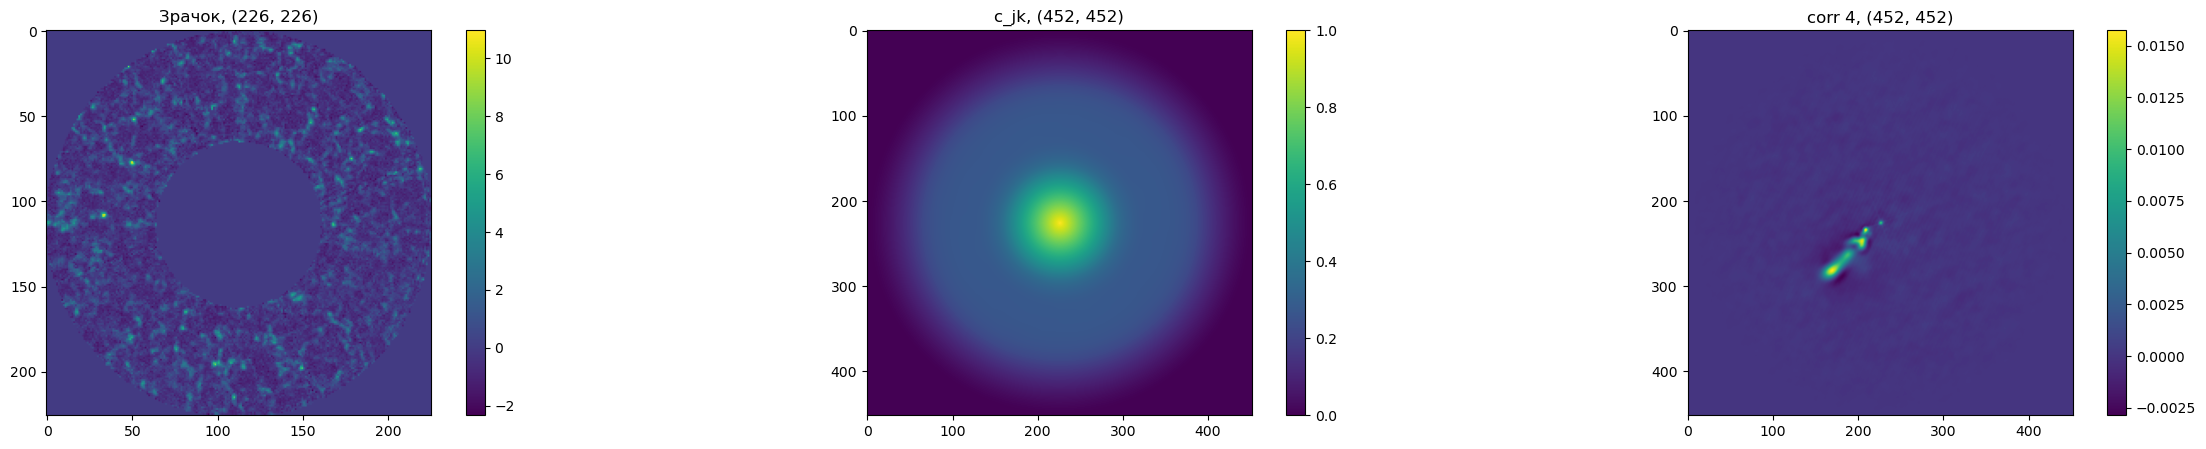

In [2]:
import time
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from scipy.ndimage import shift
from scipy.optimize import curve_fit
from skimage.filters import threshold_multiotsu, threshold_otsu, median
from astropy.io import fits

def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    
    if idx == (len(array) - 1):
        return idx, idx-1
    if idx == 0:
        return 1, 0
    else:
        if array[idx] > value:
            return idx, idx-1 
        if array[idx] < value:
            return idx+1, idx

def gamma_poly_se(X, Y, Vx, Vy, Cn2, z): 
    global cjk, t, a1, gammas, delta
    
    Cn2=Cn2*1e-14
    z=z*1000
    
    Lx = Vx*t
    Ly = Vy*t
    Xpix = Lx/delta
    Ypix = Ly/delta
    
    lv = find_nearest(a1, z)[1]
    uv = find_nearest(a1, z)[0]
    
    res = gammas[lv] + (z - a1[lv])*((gammas[uv] - gammas[lv])/(a1[uv] - a1[lv]))
    
    res = (res/(1e-13))*Cn2
    res = shift(res, (-Ypix, Xpix), order=1)  

    res = res * cjk
    return res

# ----------- входные параметры
D = 2.5
latency = 4
data_dir = 'D:/astro/domecam'
dist0 = 2
file='data/20210130l_m2km_corr_4_blur.gz'
gammas_type = 'blur'

sec_per_frame = 0.01
t = sec_per_frame *latency

# ---------- считывание зрачка, картины мерцаний, автокорреляции зрачка и гамм

if gammas_type == 'orig':
    print('lol')

if gammas_type == 'blur':
    data = np.loadtxt(f'{data_dir}/{file}')
    gammas = np.load(f'{data_dir}/gammas_blur.npy')


pupil = np.loadtxt(f'{data_dir}/frame.gz')
cjk = np.loadtxt(f'{data_dir}/cjk.gz')
a1 = np.loadtxt(f'{data_dir}/z.gz')

# ------------ шаг для функции гамма
x = np.linspace(-data.shape[1]//2, data.shape[1]//2-1, data.shape[1])
y = np.linspace(-data.shape[0]//2, data.shape[0]//2-1, data.shape[0])
X, Y = np.meshgrid(x, y)

delta = D/(pupil.shape[0]) # шаг по пикселю


fig, (ax, ax2, ax3) = plt.subplots(1, 3, figsize=(30, 5))

fig.colorbar(ax.imshow(pupil), ax = ax)
ax.grid(False)
ax.set_title(f'Зрачок, {pupil.shape}')

fig.colorbar(ax2.imshow(cjk), ax=ax2)
ax2.grid(False)
ax2.set_title(f'c_jk, {cjk.shape}')

fig.colorbar(ax3.imshow(data), ax=ax3)
ax3.grid(False)
ax3.set_title(f'corr 4, {data.shape}')

def CLEAN(dirty, gain=None, thresh=None, niter=None, window=None):
    global t, delta
    st = time.perf_counter()
    comps = np.zeros(dirty.shape)
    res = np.array(dirty) 
    cl = np.zeros(dirty.shape)
    
    k = 5
    res2 = np.array(dirty)
    cl2 = np.zeros(dirty.shape)

    tmp = 0
    tmp_Vx = []
    tmp_Vy = []
    all_params = []
    all_errors = []
    reason = 'empty'
    for i in range(niter):
        my, mx = np.unravel_index(np.argmax(res), res.shape)
        mval=res[my, mx]*gain
        comps[my, mx]+=mval
        
        Vy = (dirty.shape[0]//2-my)*delta/t
        Vx = -(dirty.shape[1]//2-mx)*delta/t
        
        tmp_Vx.append(Vx)
        tmp_Vy.append(Vy)
                
        if i > 5\
        and tmp_Vx[i-4] == tmp_Vx[i] and tmp_Vx[i-3] == tmp_Vx[i] and tmp_Vx[i-2] == tmp_Vx[i] and tmp_Vx[i-1] == tmp_Vx[i]\
        and tmp_Vy[i-4] == tmp_Vy[i] and tmp_Vy[i-3] == tmp_Vy[i] and tmp_Vy[i-2] == tmp_Vy[i] and tmp_Vy[i-1] == tmp_Vy[i]:
            all_params = np.array(all_params)
            all_params = all_params[:-4, :]
            all_errors = np.array(all_errors)
            all_errors = all_errors[:-4, :]
            reason = 'Stucked!'
            print('Stucked!')
            break
        
        if int(Vx) == 0 and int(Vy) == 0:
            print('\nDome turbulence')
            p0_Cn2 = (res[my, mx]/np.max(gamma_poly_se(X, Y, Vx, Vy, 10, 2))) * 10
            myParams = [0, 0, p0_Cn2, 2]
            psf, params, errors = multi_speckle_fit(myParams, ydata=res, window=window//2)
            print('-initial value:', res[my, mx])
            res -= psf*0.99
        else:
            p0_Cn2 = (res[my, mx]/np.max(gamma_poly_se(X, Y, Vx, Vy, 10, 15))) * 10
            myParams = [Vx, Vy, p0_Cn2, (15+5*np.sin(np.random.uniform(-np.pi, np.pi)))]  
            psf, params, errors = multi_speckle_fit(myParams, ydata=res, window=window)
            print('-initial value:', res[my, mx])
            res -= psf*gain
        
        cl += psf*gain
        all_params.append(params)
        all_errors.append(errors)
        print('-residual value:', res[my, mx])
        
        if (i+1)%k == 0:
            print('\nCheckpoint fitting...')
#             fit, params2 = one_speckle_fit(all_params[i-(k-1):i+1], res2)
#             res2 -= fit
#             cl2 += fit
            
#             plt.figure()
#             plt.imshow(res2)
#             plt.show()
            
#             plt.figure()
#             plt.imshow(cl2)
#             plt.show()
        print(' ')
        
        tmp = i
        if np.max(res) < thresh:
            reason = 'Thresh reached!'
            print('Thresh reached!')
            break
    print('Total iterations:', tmp+1)
    print('time:', time.perf_counter()-st)
    
    if reason == 'empty':
        reason = 'Max number of iteration reached!'
    conf = [reason, tmp+1, time.perf_counter()-st]
    return comps, res, cl, np.array(all_params), np.array(all_errors), conf


def multi_speckle_fit(params, ydata=None, window=None):
    global t, delta
    st=time.perf_counter()  
    def speckle_fit(params, ydata, window=None):
        k=window
        def _g(one_dim_x, *args): 
            arr = np.zeros(one_dim_x[0].shape)
            Vx = args[0]
            Vy = args[1]
            Cn2 = args[2]
            z = args[3]
            arr += gamma_poly_se(one_dim_x[0], one_dim_x[1], Vx, Vy, Cn2, z)[Ypix1-k:Ypix1+k, Xpix1-k:Xpix1+k].ravel()
#             arr += gamma_poly_se(one_dim_x[0], one_dim_x[1], Vx, Vy, Cn2, z).ravel()
            return arr
        
        xcoord = params[0]
        ycoord = params[1]
        cr = ydata.shape[0]//2, ydata.shape[1]//2
        
        Xpix1 = int(xcoord*t/delta) + cr[1]
        Ypix1 = -int(ycoord*t/delta) + cr[0]
        
        fit = np.zeros(ydata.shape)
        ydata = ydata[Ypix1-k:Ypix1+k, Xpix1-k:Xpix1+k]
        
        plt.figure()
        plt.imshow(ydata)
        plt.colorbar()
        plt.show()
        
        x = np.linspace(-ydata.shape[1]//2, ydata.shape[1]//2-1, ydata.shape[1])
        y = np.linspace(-ydata.shape[0]//2, ydata.shape[0]//2-1, ydata.shape[0])
        X, Y = np.meshgrid(x, y)
        
        xdata = np.vstack((X.ravel(), Y.ravel()))
        
        ydata = ydata.ravel()

        bounds = [[-np.inf, -np.inf, 0, 0], [np.inf, np.inf, np.inf, np.inf]]
        popt, pcov = curve_fit(_g, xdata, ydata, p0=params, bounds=bounds)
        
        fit += gamma_poly_se(X, Y, *popt)        

        return fit, popt[0], popt[1], popt[2], popt[3], np.sqrt(np.diag(pcov))
        
    res = np.zeros(data.shape)
    print(f'Speckle fitting: {params[0]} {params[1]} {1e-14*params[2]} {1000*params[3]}')
    fit, Vx, Vy, Cn2, z, errors = speckle_fit(params, ydata, window=window)
    
    xcoord = int(Vx*t/delta)
    ycoord = int(Vy*t/delta)
    res +=fit        
    print(f'Fitted parametrs: {Vx:.2f} {Vy:.2f} {1e-14*Cn2} {1000*z}')
    print('time:', time.perf_counter()-st)    
    return res, [Vx, Vy, Cn2, z], errors

def one_speckle_fit(params=None, data=None): 
    def _g(M, *args): 
        x, y = M
        arr = np.zeros(x.shape)
        for i in range(len(args)//4):
            arr += gamma_poly_se(x, y, *args[i*4:i*4+4]).ravel()
        return arr
        
    p0 = [p for prms in params for p in prms]
        
    st=time.perf_counter()
       
    x = np.linspace(-data.shape[1]//2, data.shape[1]//2-1, data.shape[1])
    y = np.linspace(-data.shape[0]//2, data.shape[0]//2-1, data.shape[0])
    X, Y = np.meshgrid(x, y)

    fit = np.zeros(X.shape) 
    xdata = np.vstack((X.ravel(), Y.ravel())) 
    ydata = data.ravel()
        
    lb = [-np.inf, -np.inf, 0, 0]
    lb = np.tile(lb, len(p0)//4)
    ub = [np.inf, np.inf, np.inf, np.inf]
    ub = np.tile(ub, len(p0)//4)
        
    popt, pcov = curve_fit(_g, xdata, ydata, p0, bounds=[lb, ub])

    for i in range(len(popt)//4):
        fit += gamma_poly_se(X, Y, *popt[i*4:i*4+4])

    print(f'Time: {time.perf_counter()-st:.4f}')

    for i in range(len(popt)//4):
        print(*popt[i*4:i*4+4])

    return fit, popt

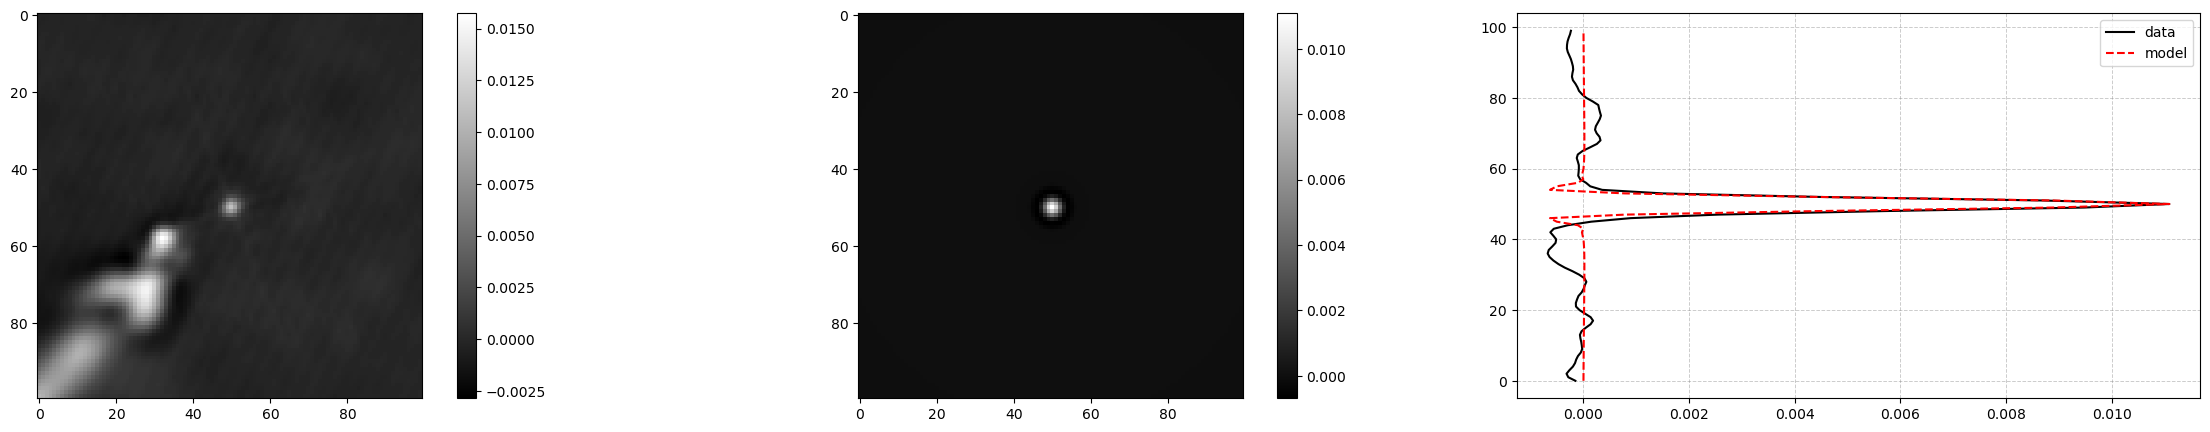

In [39]:
fig, (ax, ax2, ax3) = plt.subplots(1, 3, figsize=(30, 5))
k=50
data_tmp = data[226-k:226+k, 226-k:226+k]
model_tmp = gamma_poly_se(X, Y, 0, 0, 15*0.915327944230, 2)[226-k:226+k, 226-k:226+k]

fig.colorbar(ax.imshow(data_tmp, cmap='gray'), ax = ax)
fig.colorbar(ax2.imshow(model_tmp, cmap='gray'), ax = ax2)

ax3.plot(data_tmp[:, k], range(2*k), color='black', label='data')
ax3.plot(model_tmp[:, k], range(2*k), color='red', ls='--', label='model')
ax3.grid(color='grey', linestyle='--', linewidth=0.7, alpha=0.4)

ax3.legend()

fig.savefig(f'D:/astro/model.png', bbox_inches='tight')

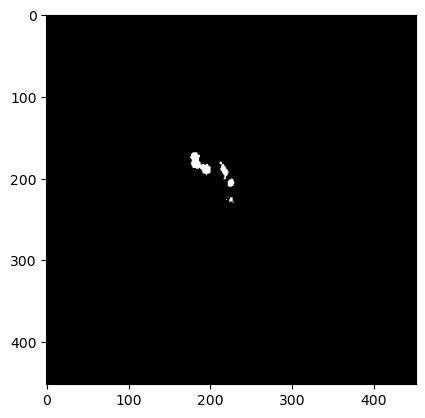

In [23]:
gain=1
niter=50
window=15
thresh_type = 'multiotsu'

if thresh_type == 'otsu':
    thresh = threshold_otsu(data)
if thresh_type == 'multiotsu':
    thresh = threshold_multiotsu(data)[0]
plt.imshow(data>thresh, cmap='gray')

Speckle fitting: -2.4889380530973453 9.679203539823009 8.580237500496266e-15 12716.179199190776


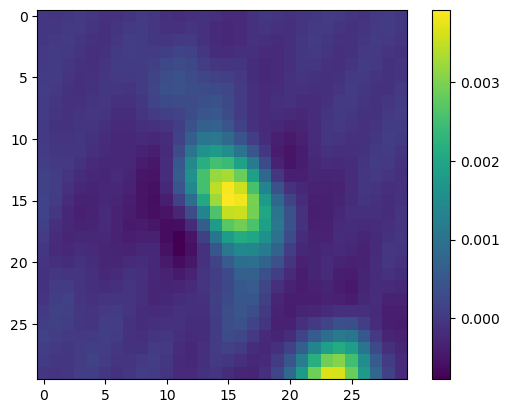

Fitted parametrs: -2.41 9.79 1.8745959178864003e-14 6723.956679731125
time: 0.6481710000000476
-initial value: 0.003919986444799408
-residual value: 0.00020523325572007574
 
Speckle fitting: -0.27654867256637167 5.530973451327434 6.8687783647837794e-15 18297.290978004592


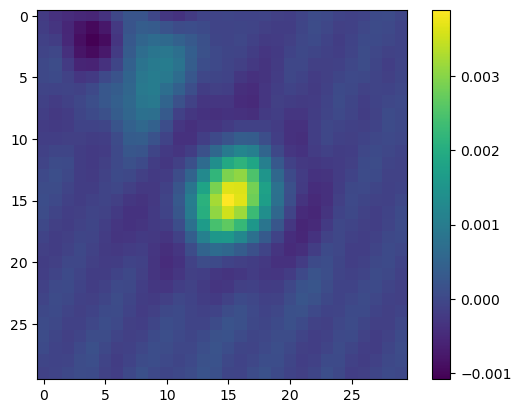

Fitted parametrs: -0.18 5.62 1.9000607381132772e-14 5568.983735214782
time: 0.6128146999999444
-initial value: 0.003889391507668301
-residual value: 7.285538169465302e-05
 

Dome turbulence
Speckle fitting: 0 0 1.3608372769284763e-14 2000


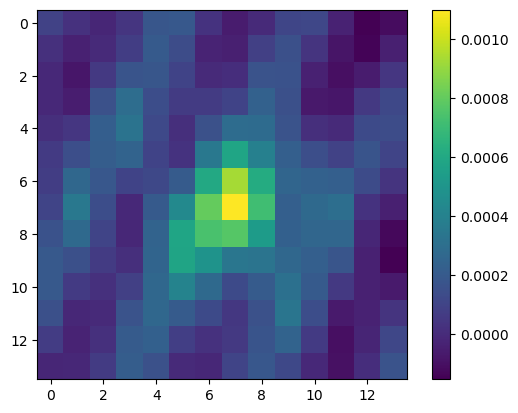

Fitted parametrs: -0.12 -0.05 1.0421943817484227e-15 11378.803632384015
time: 1.0112960999999814
-initial value: 0.0010987841435678059
-residual value: 0.0005561851018289887
 
Speckle fitting: -8.019911504424778 9.679203539823009 2.6353776042921128e-15 19476.623676856794


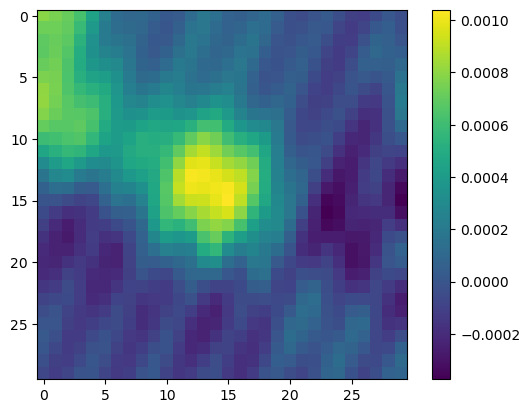

Fitted parametrs: -9.03 10.68 1.0408597663596623e-15 36201.60080548638
time: 1.7214762999999493
-initial value: 0.0010402155243799983
-residual value: 0.0005018897235886557
 
Speckle fitting: -1.65929203539823 8.573008849557521 2.046785921009259e-15 10982.561052639483


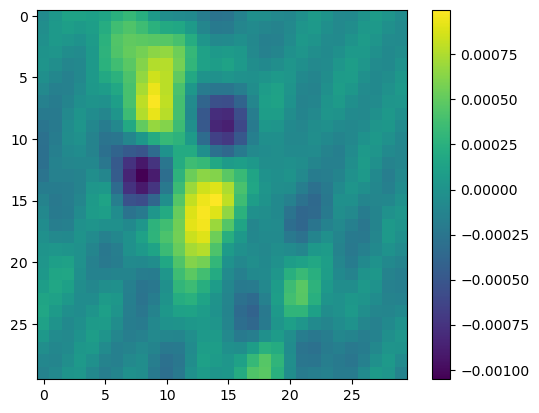

Fitted parametrs: -1.94 8.20 4.986399577922562e-15 6293.547015315886
time: 1.4511687000000393
-initial value: 0.0009979341908871089
-residual value: 0.0002002530121181684

Checkpoint fitting...
 
Speckle fitting: -3.0420353982300883 10.785398230088495 2.312132789948482e-15 10129.755747048517


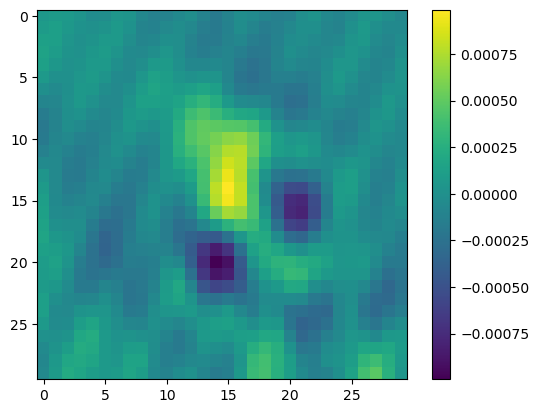

Fitted parametrs: -3.13 11.38 4.4257042032341366e-15 7575.7569472016785
time: 1.125308700000005
-initial value: 0.0009883233803421529
-residual value: 0.0003208708371069941
 
Speckle fitting: -12.444690265486726 14.380530973451327 3.797106388542294e-15 12846.353505020568


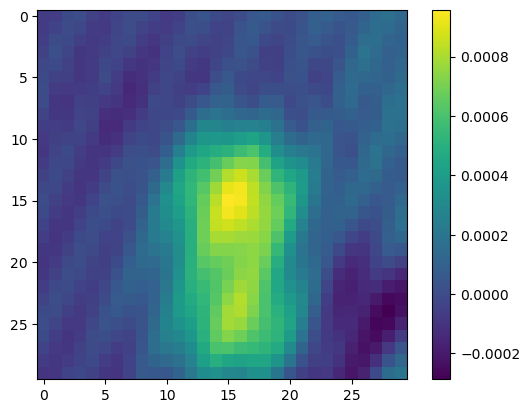

Fitted parametrs: -12.38 13.60 1.4525782802857307e-15 36842.054888048515
time: 0.45075409999992644
-initial value: 0.0009582274841062068
-residual value: 0.00026490344963079097
 

Dome turbulence
Speckle fitting: 0 0 6.8771141786866005e-15 2000


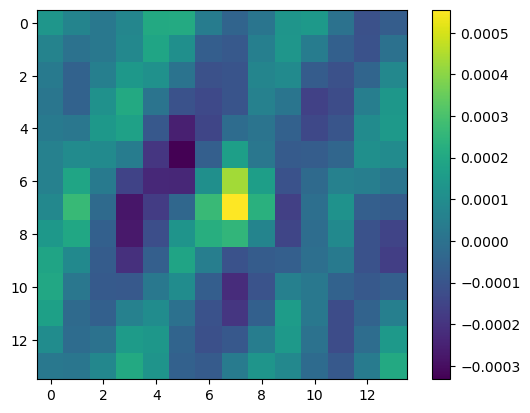

Fitted parametrs: -0.00 0.01 6.046098408061327e-15 1384.518261696031
time: 1.614305599999966
-initial value: 0.0005552804983489093
-residual value: 0.0002646690829700592
 
Speckle fitting: -8.019911504424778 9.679203539823009 1.36885138031121e-15 19120.294620910456


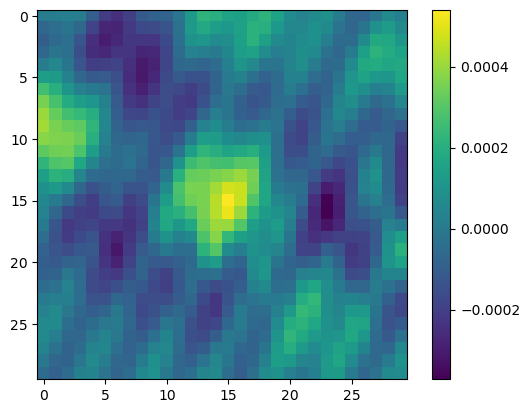

Fitted parametrs: -8.19 9.77 2.307243698382152e-15 9090.913079192955
time: 1.0728778999999804
-initial value: 0.0005403022527206999
-residual value: 8.884403066280674e-06
 
Speckle fitting: -3.0420353982300883 10.508849557522124 1.1715976648674037e-15 11175.322190787841


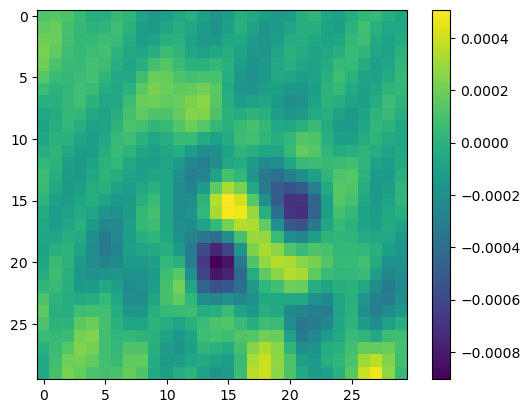

Fitted parametrs: -2.86 10.30 1.1496276986034571e-14 1964.302635097891
time: 1.167146799999955
-initial value: 0.0005082706765877682
-residual value: 9.461368491244394e-05

Checkpoint fitting...
 
Speckle fitting: 0.27654867256637167 6.63716814159292 8.935879343489669e-16 12625.08185658665


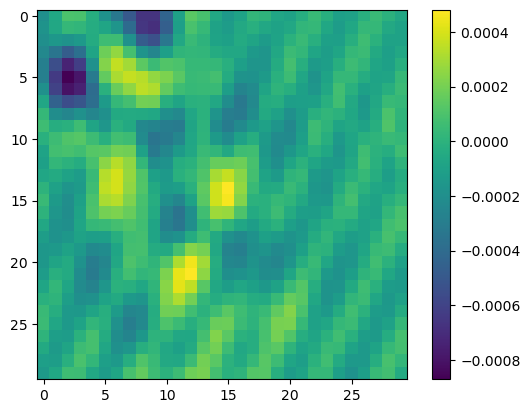

Fitted parametrs: 0.28 6.66 2.7633132650176505e-15 3796.1406361767777
time: 1.9934964000000264
-initial value: 0.0004819116706058298
-residual value: 0.00011574474614766051
 
Speckle fitting: -0.5530973451327433 4.701327433628318 8.272447675122041e-16 19878.707947159986


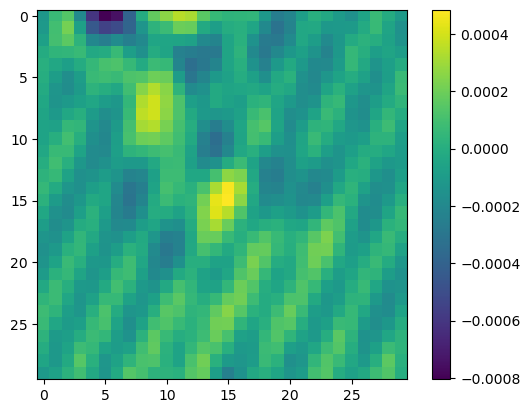

Fitted parametrs: -0.72 4.64 6.5036679571547465e-15 2165.4371292166966
time: 0.9690765000000283
-initial value: 0.0004847239073248249
-residual value: 7.030128003580053e-05
 
Speckle fitting: -12.444690265486726 11.338495575221238 1.5468006599266834e-15 17535.247036141973


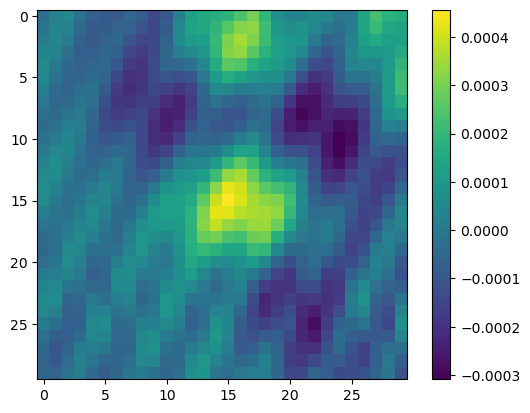

Fitted parametrs: -12.29 11.17 2.2261156480791296e-15 10579.501214954953
time: 0.6887714000000642
-initial value: 0.0004568597292686547
-residual value: 1.526449426915552e-05
 
Speckle fitting: -2.2123893805309733 6.913716814159292 7.493796643264337e-16 11704.275669186793


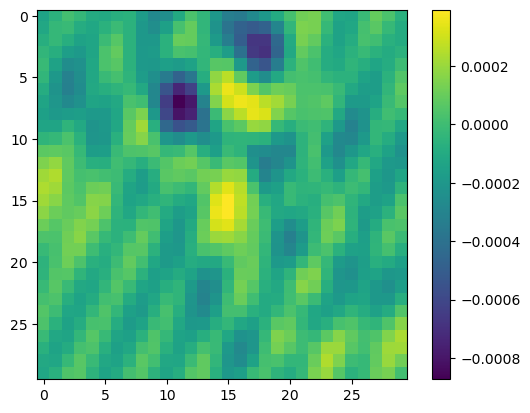

Fitted parametrs: -2.21 6.73 3.304213474252058e-15 3499.580837662954
time: 1.5832841000000144
-initial value: 0.0003924283222617451
-residual value: 3.498416440003607e-05
 
Speckle fitting: -1.9358407079646016 9.126106194690266 7.6109251862418265e-16 19930.54496739193


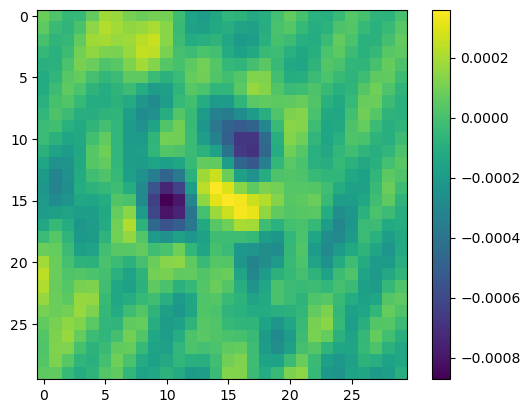

Fitted parametrs: -1.87 9.13 6.745736582899191e-15 2364.271943473988
time: 1.766898900000001
-initial value: 0.0003600505186925423
-residual value: -7.263133860228892e-05

Checkpoint fitting...
 
Speckle fitting: -12.168141592920353 14.933628318584072 1.4076719298938082e-15 16063.32083431736


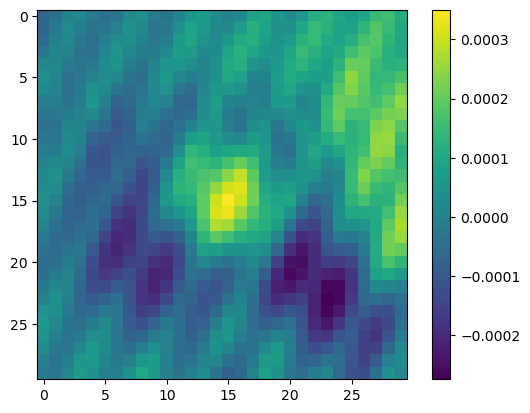

Fitted parametrs: -12.20 15.00 2.4591491358252833e-15 8263.175686464878
time: 0.6762317999999823
-initial value: 0.00035034063325955697
-residual value: 1.24594121052838e-05
 
Thresh reached!
Total iterations: 16
time: 18.768043199999966


Text(0.5, 1.0, 'max: 0.0003, min: -0.0008')

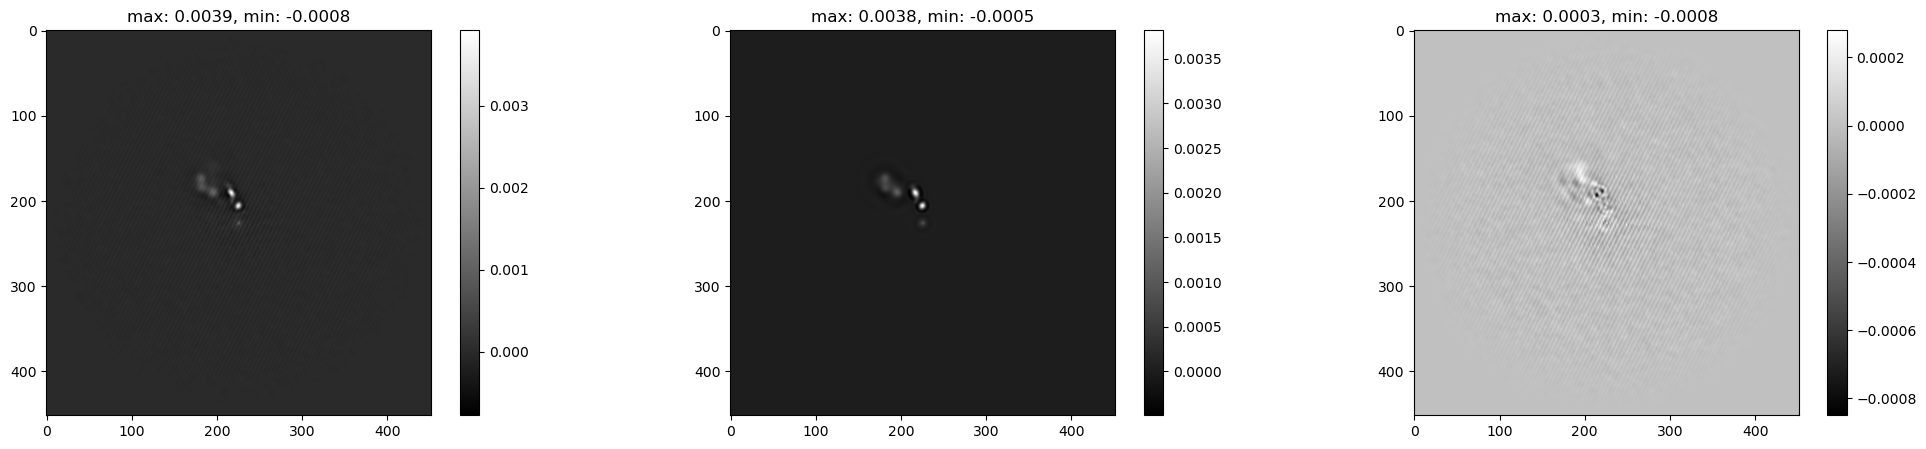

In [27]:
comps, residual, clean, params, errors, conf = CLEAN(data, gain=gain, thresh=thresh, niter=50, window=window)

fig, (ax, ax2, ax3) = plt.subplots(1, 3, figsize=(25, 5)) 
fig.colorbar(ax.imshow(data, cmap='gray'), ax=ax) 
fig.colorbar(ax2.imshow(clean, cmap='gray'), ax=ax2) 
fig.colorbar(ax3.imshow(residual, cmap='gray'), ax=ax3) 
ax.set_title(f'max: {np.max(data):.4f}, min: {np.min(data):.4f}') 
ax2.set_title(f'max: {np.max(clean):.4f}, min: {np.min(clean):.4f}') 
ax3.set_title(f'max: {np.max(residual):.4f}, min: {np.min(residual):.4f}')

              Vx         Vy       Cn2          z
7  -4.226956e-09   0.010774  0.604610   1.384518
9  -2.857521e+00  10.296593  1.149628   1.964303
11 -7.153892e-01   4.639042  0.650367   2.165437
14 -1.866472e+00   9.126106  0.674574   2.364272
13 -2.212389e+00   6.726241  0.330421   3.499581
10  2.765488e-01   6.662565  0.276331   3.796141
1  -1.813116e-01   5.616475  1.900061   5.568984
4  -1.935841e+00   8.195867  0.498640   6.293547
0  -2.405910e+00   9.785683  1.874596   6.723957
5  -3.131993e+00  11.382536  0.442570   7.575757
15 -1.219514e+01  14.996187  0.245915   8.263176
8  -8.192019e+00   9.766399  0.230724   9.090913
12 -1.228950e+01  11.169646  0.222612  10.579501
2  -1.219878e-01  -0.054663  0.104219  11.378804
3  -9.029153e+00  10.683944  0.104086  36.201601
6  -1.238344e+01  13.595500  0.145258  36.842055
      err_Vx    err_Vy   err_Cn2     err_z
0   0.022109  0.022111  0.112684  0.245858
1   0.011015  0.011052  0.061747  0.107635
2   0.048499  0.049223  0.011885  0.86

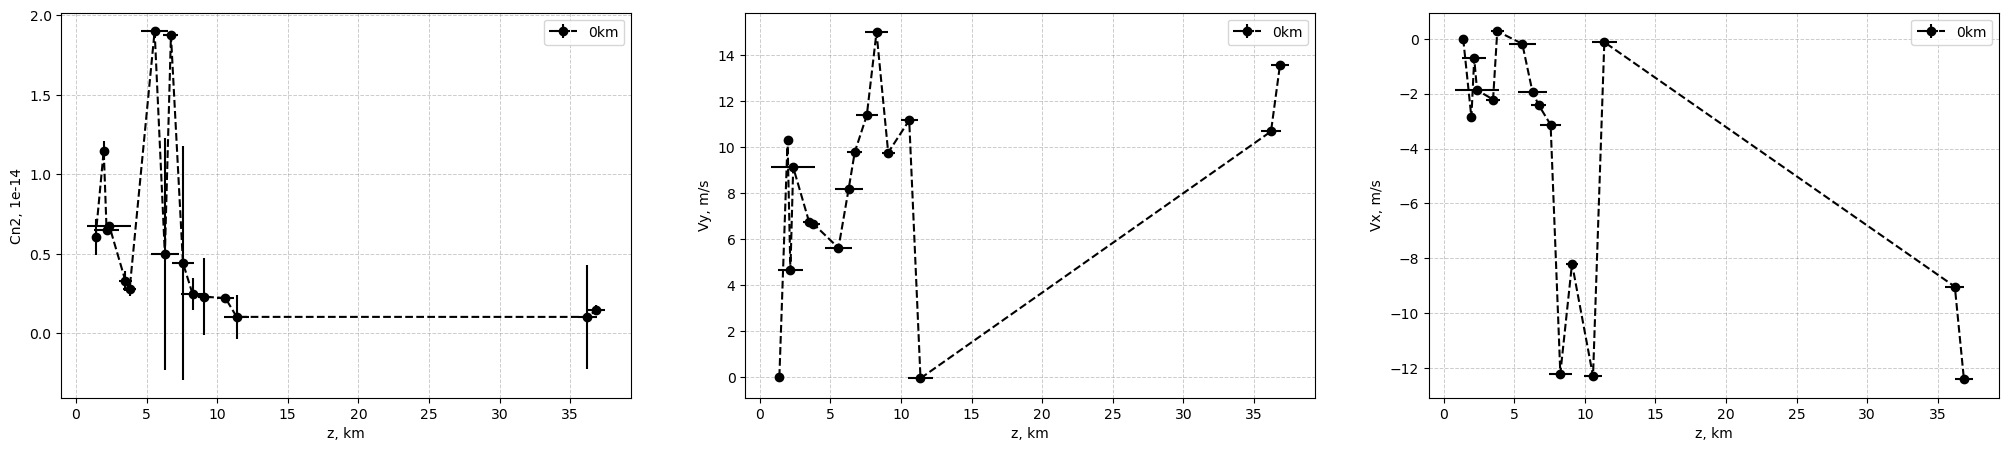

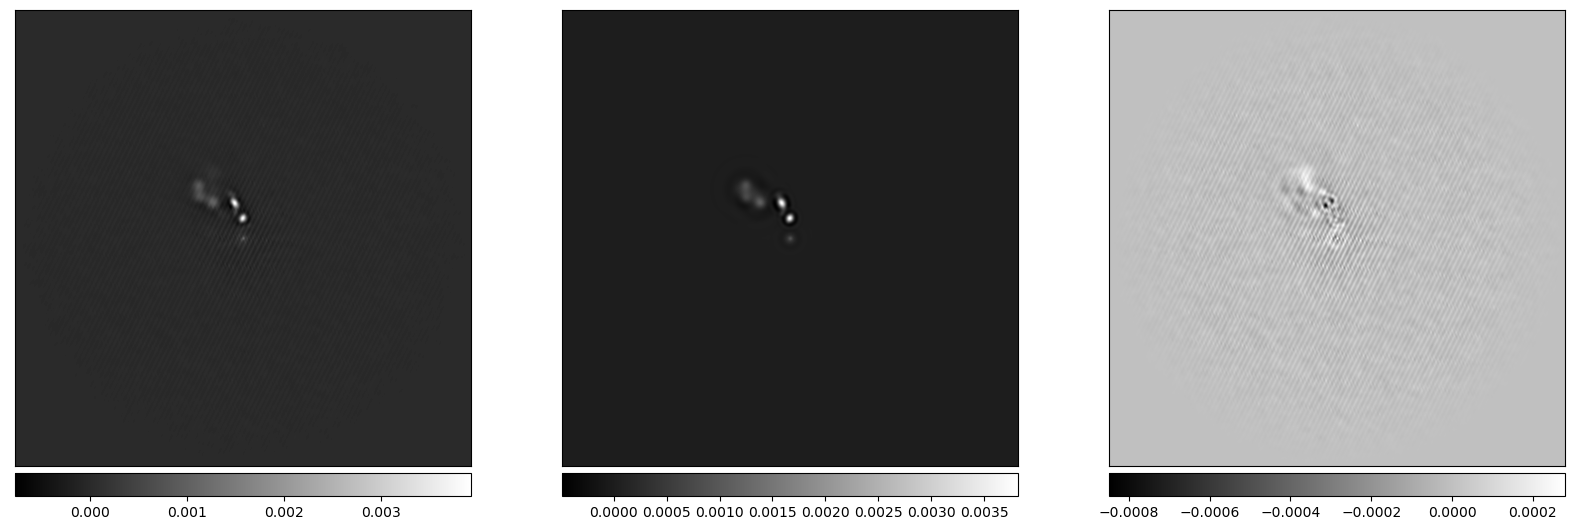

In [28]:
df = pd.DataFrame(params, columns = ['Vx','Vy','Cn2', 'z'])
df = df.sort_values(by=['z'])

df_err = pd.DataFrame(errors, columns = ['err_Vx','err_Vy','err_Cn2', 'err_z'])

# df2 = pd.DataFrame(params2, columns = ['Vx','Vy','Cn2', 'z'])
# df2 = df2.sort_values(by=['z'])
# df2['z'] = df2['z'] - 2 

# df_err2 = pd.DataFrame(errors2, columns = ['err_Vx','err_Vy','err_Cn2', 'err_z'])

print(df)
print(df_err)

# print(df2)
# print(df_err2)

fig, (ax, ax2, ax3) = plt.subplots(1, 3, figsize=(25, 5)) 

ax.errorbar(df['z'], df['Cn2'], yerr=df_err['err_Cn2'], xerr=df_err['err_z'], fmt='o--', color='black', label='0km')
ax2.errorbar(df['z'], df['Vy'], yerr=df_err['err_Vy'], xerr=df_err['err_z'], fmt='o--', color='black', label='0km')
ax3.errorbar(df['z'], df['Vx'], yerr=df_err['err_Vx'], xerr=df_err['err_z'], fmt='o--', color='black', label='0km')

# ax.errorbar(df2['z'], df2['Cn2'], yerr=df_err2['err_Cn2'], xerr=df_err2['err_z'], fmt='o--', color='red', label='-2km')
# ax2.errorbar(df2['z'], df2['Vy'], yerr=df_err2['err_Vy'], xerr=df_err2['err_z'], fmt='o--', color='red', label='-2km')
# ax3.errorbar(df2['z'], df2['Vx'], yerr=df_err2['err_Vx'], xerr=df_err2['err_z'], fmt='o--', color='red', label='-2km')

ax.legend()
ax2.legend()
ax3.legend()

ax.set_ylabel('Cn2, 1e-14')
ax.set_xlabel('z, km')
ax2.set_ylabel('Vy, m/s')
ax2.set_xlabel('z, km')
ax3.set_ylabel('Vx, m/s')
ax3.set_xlabel('z, km')

ax.grid(color='grey', linestyle='--', linewidth=0.7, alpha=0.4)
ax2.grid(color='grey', linestyle='--', linewidth=0.7, alpha=0.4)
ax3.grid(color='grey', linestyle='--', linewidth=0.7, alpha=0.4)
fig.savefig(f'{data_dir}/results/profile.png', bbox_inches='tight')

sum_cn2 = np.sum(df['Cn2'])*1e-14
print()
print('Cn2:', sum_cn2)
lambda_ = 500 * pow(10, -9)
r0 = pow(0.423 * pow((2*np.pi/lambda_), 2) * sum_cn2, -3/5)
seeing = 206265 * 0.98 * lambda_/r0
print('seeing:', seeing)


fig, (ax, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 10)) 
fig.colorbar(ax.imshow(data, cmap='gray'), orientation="horizontal", pad=0.01, ax=ax) 
fig.colorbar(ax2.imshow(clean, cmap='gray'), orientation="horizontal", pad=0.01, ax=ax2) 
fig.colorbar(ax3.imshow(residual, cmap='gray'), orientation="horizontal", pad=0.01, ax=ax3) 

ax.set_xticks([])
ax.set_yticks([])
ax2.set_xticks([])
ax2.set_yticks([])
ax3.set_xticks([])
ax3.set_yticks([])

fig.savefig(f'{data_dir}/results/CLEAN.png', bbox_inches='tight')

with open(f'{data_dir}/results/log.txt', 'w') as f:
    print(f'file: {file}', file=f)
    print('\n-------- General settings -------', file=f)
    print(f'MODE: {gammas_type}', file=f)
    print(f'latency: {latency}', file=f)
    print('\n-------- CLEAN settings -------', file=f)
    print(f'gain: {gain}', file=f)
    print(f'thresh: {thresh_type}', file=f)
    print(f'niter: {niter}', file=f)
    print(f'window: {window}', file=f)
    print('\n-------- CLEAN output -------', file=f)
    print(f'message: {conf[0]}', file=f)
    print(f'num. of iters: {conf[1]}', file=f)
    print(f'time: {conf[2]}', file=f)
    print('\n-------- Results -------', file=f)
    print(f'{df}', file=f)
    print('', file=f)
    print(f'{df_err}', file=f)
    print('', file=f)
    print(f'total cn2: {sum_cn2}', file=f)
    print(f'seeing, 500 nm: {seeing:.2f}', file=f)